## Progetto fondamenti di machine learning Flavio Orizio

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [73]:
#carico il dataset
df = pd.read_csv("train.csv")
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [74]:
RANDOM_SEED = 42

In [75]:
df.shape

(381109, 12)

In [76]:
#elimino id
df = df.drop("id", axis=1)

In [77]:
df.dtypes

Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

### pulizia features categoriche

In [78]:
print(df["Gender"].value_counts())
print(df["Vehicle_Age"].value_counts())
print(df["Vehicle_Damage"].value_counts())

Male      206089
Female    175020
Name: Gender, dtype: int64
1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64
Yes    192413
No     188696
Name: Vehicle_Damage, dtype: int64


In [79]:
gender_map = {"Male":0, "Female":1}
v_age_map = {"< 1 Year":0,"1-2 Year":1,"> 2 Years":2}
v_damage_map = {"No":0, "Yes":1}

In [80]:
df["Gender"] = df["Gender"].map(gender_map)
df["Vehicle_Age"] = df["Vehicle_Age"].map(v_age_map)
df["Vehicle_Damage"] = df["Vehicle_Damage"].map(v_damage_map)

### controllo eventuali NA

In [81]:
df.isna().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [82]:
#divido target dal resto
X = df.drop("Response", axis=1).values
y = df["Response"].values

In [83]:
#distribuzione variabile target, molto sbilanciata
counts = np.bincount(y)

for i in range(len(counts)):
    print("Valore", {i},":",round((counts[i]/y.shape[0])*100), "%") 

Valore {0} : 88 %
Valore {1} : 12 %


In [84]:
#divisione in train e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)

In [85]:
#standardizzazione
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

### Gridsearch mi permette di scoprire i migliori iperparametri

### modello LogisticRegression 
- class_weight = balanced
- iperparametri trovati da grid search 

In [86]:
def perform_grid_search(X_train, y_train):
    # griglia di parametri da testare
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2'],'solver': ['liblinear', 'saga']}
    grid = GridSearchCV(LogisticRegression(), param_grid, scoring='recall', cv=5)
    # fit
    grid.fit(X_train, y_train)
    # migliori parametri
    print(grid.best_params_)

In [87]:
#perform_grid_search(X_train, y_train)
# un po' lungo, risultato finale: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}

In [88]:

lr = LogisticRegression(class_weight="balanced", C=0.001, penalty="l1", solver="liblinear")
lr.fit(X_train, y_train)

LogisticRegression(C=0.001, class_weight='balanced', penalty='l1',
                   solver='liblinear')

In [89]:
#previsioni sul set di train
y_pred_train = lr.predict(X_train)
y_pred_proba_train = lr.predict_proba(X_train)

In [90]:
#previsioni sul set di test
y_pred_test = lr.predict(X_test)
y_pred_proba_test = lr.predict_proba(X_test)

In [91]:
#log loss train
log_loss(y_train, y_pred_proba_train)

0.49859132557970337

In [92]:
#log loss test
log_loss(y_test, y_pred_proba_test)

0.4950977323270891

In [93]:
#classification report train
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.99      0.59      0.74    234204
           1       0.25      0.98      0.40     32572

    accuracy                           0.64    266776
   macro avg       0.62      0.78      0.57    266776
weighted avg       0.90      0.64      0.70    266776



In [94]:
#classification report test
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.59      0.74    100195
           1       0.25      0.98      0.40     14138

    accuracy                           0.64    114333
   macro avg       0.62      0.79      0.57    114333
weighted avg       0.90      0.64      0.70    114333



In [95]:
#matrice confusione
def plot_confusion_matrix(y_true, y_pred, labels = ["Negative", "Positive"], show_precision_recall=False):

    cm = confusion_matrix(y_true, y_pred) 

    df_cm = pd.DataFrame(cm, index=labels,
                         columns=["Predicted "+labels[0], "Predicted "+labels[1]])
    
    sns.heatmap(df_cm, annot=True, fmt="g")

    if show_precision_recall:
        plt.text(0, -0.1, f"Precision: {cm[1][1]/(cm[1][1]+cm[0][1]):.3f}")
        plt.text(1, -0.1, f"Recall: {cm[1][1]/(cm[1][1]+cm[1][0]):.3f}")


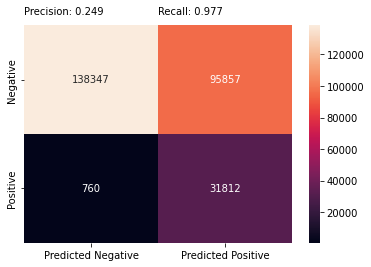

In [96]:
#matrice confusione train set
plot_confusion_matrix(y_train, y_pred_train, show_precision_recall=True)

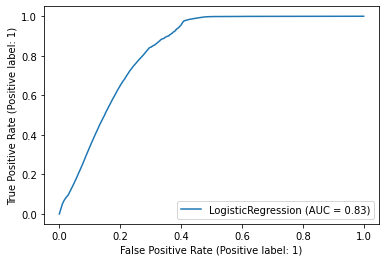

In [97]:
#ROC train set
RocCurveDisplay.from_estimator(lr, X_train, y_train)

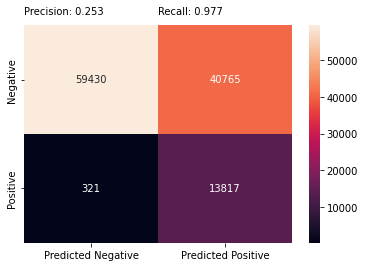

In [98]:
#matrice confusione test set
plot_confusion_matrix(y_test, y_pred_test, show_precision_recall=True)

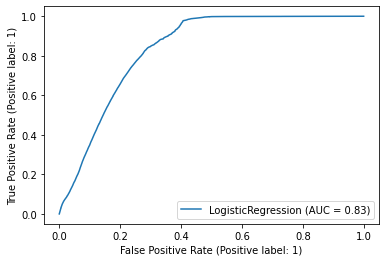

In [99]:
#ROC test set
RocCurveDisplay.from_estimator(lr, X_test, y_test)

### modifico la recall per perdere meno clienti che faranno l'assicurazione

              precision    recall  f1-score   support

           0       1.00      0.52      0.69    234204
           1       0.22      1.00      0.37     32572

    accuracy                           0.58    266776
   macro avg       0.61      0.76      0.53    266776
weighted avg       0.90      0.58      0.65    266776



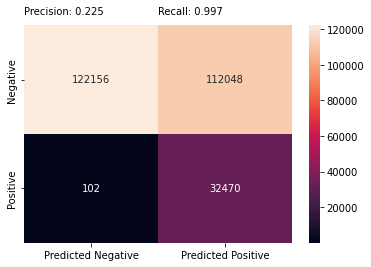

In [100]:
y_pred_train = np.where(y_pred_proba_train[:,1]>0.15,1,0)
print(classification_report(y_train, y_pred_train))
plot_confusion_matrix(y_train, y_pred_train, show_precision_recall=True)

              precision    recall  f1-score   support

           0       1.00      0.52      0.69    100195
           1       0.23      1.00      0.37     14138

    accuracy                           0.58    114333
   macro avg       0.61      0.76      0.53    114333
weighted avg       0.90      0.58      0.65    114333



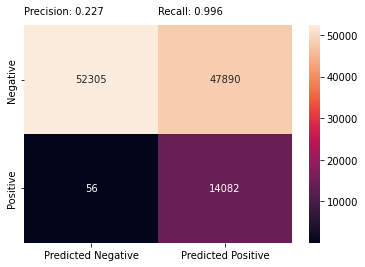

In [101]:
y_pred_test = np.where(y_pred_proba_test[:,1]>0.15,1,0)
print(classification_report(y_test, y_pred_test))
plot_confusion_matrix(y_test, y_pred_test, show_precision_recall=True)

### tecnica SMOTE per equilibrare il dataset facendo oversampling della classe minoritaria

In [102]:
#SMOTE
sm = SMOTE()
X_train_res, y_train_res = sm.fit_resample(X_train, y_train) 

In [103]:
pd.DataFrame(y_train_res).value_counts()

0    234204
1    234204
dtype: int64

In [104]:
#perform_grid_search(X_train_res, y_train_res)
# un po' lungo, risultato finale: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}

In [105]:
lr = LogisticRegression(C=0.001, penalty="l1", solver="liblinear")
lr.fit(X_train_res, y_train_res)

LogisticRegression(C=0.001, penalty='l1', solver='liblinear')

In [106]:
#previsioni sul set di train
y_pred_train_res = lr.predict(X_train_res)
y_train_res_proba = lr.predict_proba(X_train_res)
#previsioni sul set di test
y_pred_test_res = lr.predict(X_test)
y_test_res_proba = lr.predict_proba(X_test)

### modifico la recall per perdere meno clienti che faranno l'assicurazione

              precision    recall  f1-score   support

           0       1.00      0.52      0.68    234204
           1       0.68      1.00      0.81    234204

    accuracy                           0.76    468408
   macro avg       0.84      0.76      0.75    468408
weighted avg       0.84      0.76      0.75    468408



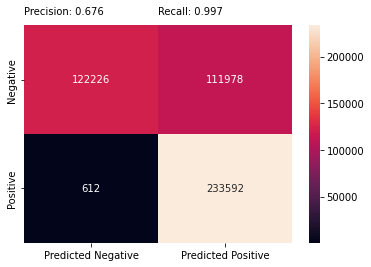

In [107]:
y_pred_train_res = np.where(y_train_res_proba[:,1]>0.15,1,0)
print(classification_report(y_train_res, y_pred_train_res))
plot_confusion_matrix(y_train_res, y_pred_train_res, show_precision_recall=True)

              precision    recall  f1-score   support

           0       1.00      0.52      0.69    100195
           1       0.23      1.00      0.37     14138

    accuracy                           0.58    114333
   macro avg       0.61      0.76      0.53    114333
weighted avg       0.90      0.58      0.65    114333



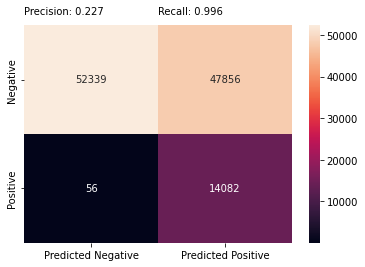

In [108]:
y_pred_test_res = np.where(y_test_res_proba[:,1]>0.15,1,0)
print(classification_report(y_test, y_pred_test_res))
plot_confusion_matrix(y_test, y_pred_test_res, show_precision_recall=True)

In [116]:
def class_report_comp(y1_true, y1_pred, y2_true, y2_pred, title1 ="First Technique", title2 = "Second Technique", train=False):
    if train:
        print("classification report training set")
    else:
        print("classification report test set")
    print(title1)
    print(classification_report(y1_true, y1_pred))
    print("-------------------------------------------------")
    print(title2)
    print(classification_report(y2_true, y2_pred))

In [110]:
y_train.shape

(266776,)

In [111]:
y_pred_train.shape

(266776,)

In [112]:
class_report_comp(y_train_res, y_pred_train_res, y_train, y_pred_train, title1="SMOTE", title2="NORMAL", train=True)

classification report training set
SMOTE
              precision    recall  f1-score   support

           0       1.00      0.52      0.68    234204
           1       0.68      1.00      0.81    234204

    accuracy                           0.76    468408
   macro avg       0.84      0.76      0.75    468408
weighted avg       0.84      0.76      0.75    468408

-------------------------------------------------
NORMAL
              precision    recall  f1-score   support

           0       1.00      0.52      0.69    234204
           1       0.22      1.00      0.37     32572

    accuracy                           0.58    266776
   macro avg       0.61      0.76      0.53    266776
weighted avg       0.90      0.58      0.65    266776



In [115]:
class_report_comp(y_test, y_pred_test_res, y_test, y_pred_test, title1="SMOTE", title2="NORMAL")

classification report test set
SMOTE
              precision    recall  f1-score   support

           0       1.00      0.52      0.69    100195
           1       0.23      1.00      0.37     14138

    accuracy                           0.58    114333
   macro avg       0.61      0.76      0.53    114333
weighted avg       0.90      0.58      0.65    114333

-------------------------------------------------
NORMAL
              precision    recall  f1-score   support

           0       1.00      0.52      0.69    100195
           1       0.23      1.00      0.37     14138

    accuracy                           0.58    114333
   macro avg       0.61      0.76      0.53    114333
weighted avg       0.90      0.58      0.65    114333



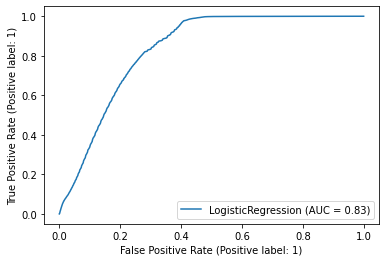

In [40]:
RocCurveDisplay.from_estimator(lr, X_train_res, y_train_res)

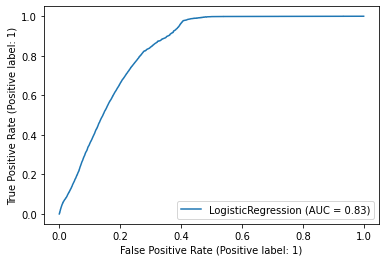

In [41]:
RocCurveDisplay.from_estimator(lr, X_test, y_test)

### Undersampling

In [42]:
rus = RandomUnderSampler(random_state=RANDOM_SEED)
X_under, y_under = rus.fit_resample(X_train, y_train)

In [43]:
pd.DataFrame(y_under).value_counts()

0    32572
1    32572
dtype: int64

In [44]:
perform_grid_search(X_under, y_under)

{'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}


In [45]:
lr = LogisticRegression(C = 0.001, penalty= "l2", solver="saga")
lr.fit(X_under, y_under)

LogisticRegression(C=0.001, solver='saga')

In [118]:
y_pred_train_under = lr.predict(X_under)
y_train_proba_under = lr.predict_proba(X_under)
y_pred_test_under = lr.predict(X_test)
y_test_proba_under = lr.predict_proba(X_test)

In [119]:
#classification report train set under vs over
class_report_comp(y_train_res, y_pred_train_res, y_under, y_pred_train_under, title1="SMOTE", title2="UNDER", train=True)

classification report training set
SMOTE
              precision    recall  f1-score   support

           0       1.00      0.52      0.68    234204
           1       0.68      1.00      0.81    234204

    accuracy                           0.76    468408
   macro avg       0.84      0.76      0.75    468408
weighted avg       0.84      0.76      0.75    468408

-------------------------------------------------
UNDER
              precision    recall  f1-score   support

           0       0.96      0.59      0.73     32572
           1       0.70      0.98      0.82     32572

    accuracy                           0.78     65144
   macro avg       0.83      0.78      0.77     65144
weighted avg       0.83      0.78      0.77     65144



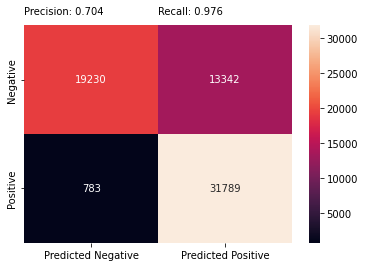

In [120]:
plot_confusion_matrix(y_under, y_pred_train_under, show_precision_recall=True)

In [126]:
#classification report test set
class_report_comp(y_test, y_pred_test_res, y_test, y_pred_test_under, title1="SMOTE", title2="NORMAL")

classification report test set
SMOTE
              precision    recall  f1-score   support

           0       1.00      0.52      0.69    100195
           1       0.23      1.00      0.37     14138

    accuracy                           0.58    114333
   macro avg       0.61      0.76      0.53    114333
weighted avg       0.90      0.58      0.65    114333

-------------------------------------------------
NORMAL
              precision    recall  f1-score   support

           0       1.00      0.52      0.69    100195
           1       0.23      1.00      0.37     14138

    accuracy                           0.58    114333
   macro avg       0.61      0.76      0.53    114333
weighted avg       0.90      0.58      0.65    114333



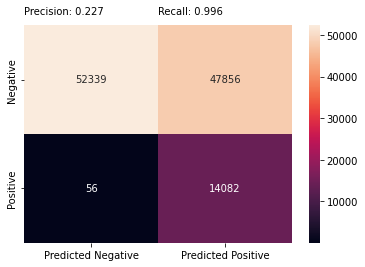

In [127]:
plot_confusion_matrix(y_test, y_pred_test_under, show_precision_recall=True)

In [123]:
#modifico la recall
y_pred_train_under = np.where(y_train_proba_under[:,1]>0.15,1,0)
y_pred_test_under= np.where(y_test_proba_under[:,1]>0.15,1,0)

In [124]:
#classification report train set under vs over
class_report_comp(y_train_res, y_pred_train_res, y_under, y_pred_train_under, title1="SMOTE", title2="UNDER", train=True)

classification report training set
SMOTE
              precision    recall  f1-score   support

           0       1.00      0.52      0.68    234204
           1       0.68      1.00      0.81    234204

    accuracy                           0.76    468408
   macro avg       0.84      0.76      0.75    468408
weighted avg       0.84      0.76      0.75    468408

-------------------------------------------------
UNDER
              precision    recall  f1-score   support

           0       0.99      0.52      0.68     32572
           1       0.68      1.00      0.81     32572

    accuracy                           0.76     65144
   macro avg       0.83      0.76      0.74     65144
weighted avg       0.83      0.76      0.74     65144



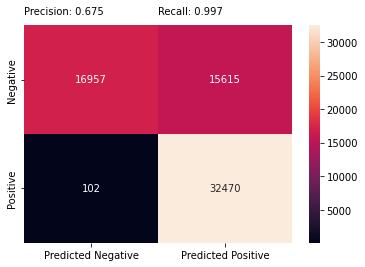

In [125]:
plot_confusion_matrix(y_under, y_pred_train_under, show_precision_recall=True)

In [54]:
class_report_comp(y_test, y_pred_test_res, y_test, y_pred_test_under, title1="SMOTE", title2="UNDER")

              precision    recall  f1-score   support

           0       1.00      0.51      0.67    100195
           1       0.22      1.00      0.36     14138

    accuracy                           0.57    114333
   macro avg       0.61      0.75      0.52    114333
weighted avg       0.90      0.57      0.63    114333



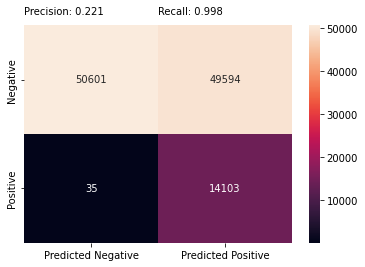

In [55]:
plot_confusion_matrix(y_test, y_pred_test_under, show_precision_recall=True)

## Modello finale:
- Kfold cross validation
- SMOTE oversampling

In [56]:
#kfold cross validation e SMOTE

kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)

#creare un ciclo che itera sui vari batch e addestrare i vari modelli
train_score = []
test_score = []

for train_index, test_index in kf.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)

    sm = SMOTE()
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train) 

    lr = LogisticRegression(C=0.001, penalty="l1", solver="liblinear")
    lr.fit(X_train_res, y_train_res)

    #previsioni sul set di train
    y_pred_train_res = lr.predict(X_train_res)
    y_train_res_proba = lr.predict_proba(X_train_res)
    #previsioni sul set di test
    y_pred_test_res = lr.predict(X_test)
    y_test_res_proba = lr.predict_proba(X_test)
    #modifico la recall
    y_pred_train_res = np.where(y_train_res_proba[:,1]>0.15,1,0)
    y_pred_test_res = np.where(y_test_res_proba[:,1]>0.15,1,0)

print("report train:")
print(classification_report(y_train_res, y_pred_train_res))
print("----------------------------------")

print("report test:")
print(classification_report(y_test, y_pred_test_res))    



report train:
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    267503
           1       0.68      1.00      0.81    267503

    accuracy                           0.76    535006
   macro avg       0.84      0.76      0.75    535006
weighted avg       0.84      0.76      0.75    535006

----------------------------------
report test:
              precision    recall  f1-score   support

           0       1.00      0.52      0.69     66896
           1       0.23      1.00      0.37      9325

    accuracy                           0.58     76221
   macro avg       0.61      0.76      0.53     76221
weighted avg       0.90      0.58      0.65     76221



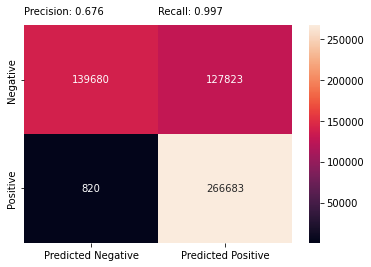

In [57]:
plot_confusion_matrix(y_train_res, y_pred_train_res, show_precision_recall=True)

None


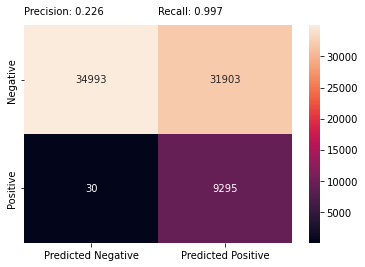

In [58]:
print(plot_confusion_matrix(y_test, y_pred_test_res, show_precision_recall=True))

### applico il mio miglior modello al dataset "test"

In [59]:
df_pred = pd.read_csv("test.csv")
df_pred.head() 

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [60]:
#elimino id
to_pred = df_pred.drop("id", axis=1)

In [61]:
to_pred["Gender"] = to_pred["Gender"].map(gender_map)
to_pred["Vehicle_Age"] = to_pred["Vehicle_Age"].map(v_age_map)
to_pred["Vehicle_Damage"] = to_pred["Vehicle_Damage"].map(v_damage_map)

In [62]:
to_pred = to_pred.values

In [63]:
predictions = lr.predict(to_pred)

In [64]:
to_exp = pd.DataFrame({"id":df_pred["id"], "prediction":predictions})

In [65]:
to_exp["prediction"].value_counts()

1    109352
0     17685
Name: prediction, dtype: int64

In [66]:
#salvo le predizioni in un file excel

#to_exp.to_excel("predictions.xlsx")